In [1]:
from datetime import datetime, timedelta
import time
import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

### Using Monte-Carlo method for finding optimal Sharpe ratios in cryptocurrency portfolios

First, we'll use the yahoo finance API to get stock price data for four coins--bitcoin, ethereum, litecoin, and ripple

In [2]:
# format for each coin is [ticker, start-date]
coins = [
    ['BTC-USD', '2013-04-28'],
    ['ETH-USD', '2015-08-07'],
    ['LTC-USD', '2013-04-28'],
    ['XRP-USD', '2013-08-04'],
    ]

In [3]:
def get_data(tickers, start_date, end_date):
    """Read in daily price(adjusted close) of asset from CSV files for a given set of dates."""
    
    # download daily price data for each of the stocks in the portfolio
    df = pdr.get_data_yahoo([x[0] for x in tickers], start=start_date, end = end_date)['Adj Close']
    df.sort_index(inplace = True)
    
    return df

In [4]:
# start date comes from the ticker with the latest start date
start_date = datetime.strptime(max([x[1] for x in coins]), '%Y-%m-%d') + timedelta(1)
yesterday = datetime.now() - timedelta(2)
crypto_prices = get_data(coins, start_date.strftime("%Y-%m-%d"), yesterday.strftime("%Y-%m-%d") )
print(crypto_prices.head())

Symbols        BTC-USD   ETH-USD  LTC-USD   XRP-USD
Date                                               
2015-08-07  260.997009  0.753325  3.85475  0.008476
2015-08-08  265.083008  0.701897  3.89859  0.008808
2015-08-09  264.470001  0.708448  3.94888  0.008750
2015-08-10  270.385986  1.067860  4.15955  0.008591
2015-08-11  266.376007  1.217440  3.98545  0.008271


#### Next, we'll define a function for calculating daily returns for our coins

In [5]:
def calc_daily_returns(df):
    return (df.pct_change())

In [6]:
crypto_daily_rets = calc_daily_returns(crypto_prices)
print(crypto_daily_rets.head())

Symbols      BTC-USD   ETH-USD   LTC-USD   XRP-USD
Date                                              
2015-08-07       NaN       NaN       NaN       NaN
2015-08-08  0.015655 -0.068268  0.011373  0.039169
2015-08-09 -0.002313  0.009333  0.012900 -0.006585
2015-08-10  0.022369  0.507323  0.053349 -0.018171
2015-08-11 -0.014831  0.140075 -0.041856 -0.037248


#### Define a function for calculating mean daily returns for our coins

In [7]:
def calc_mean_daily_returns(daily_returns):
    return (daily_returns.mean())

In [8]:
crypto_mean_daily_rets = calc_mean_daily_returns(crypto_daily_rets)
print(crypto_mean_daily_rets.head())

Symbols
BTC-USD    0.003345
ETH-USD    0.005673
LTC-USD    0.003428
XRP-USD    0.004481
dtype: float64


#### Define a function for creating covariance matrices

In [9]:
def create_covariance_matrix(daily_returns):
    return daily_returns.cov()

In [10]:
crypto_cov_matrix = create_covariance_matrix(crypto_daily_rets)
print(crypto_cov_matrix)

Symbols   BTC-USD   ETH-USD   LTC-USD   XRP-USD
Symbols                                        
BTC-USD  0.001553  0.001230  0.001434  0.000994
ETH-USD  0.001230  0.003968  0.001716  0.001418
LTC-USD  0.001434  0.001716  0.003267  0.001705
XRP-USD  0.000994  0.001418  0.001705  0.006297


#### Below is a function to calculate and return a dataframe with portfolio returns, standard deviations, and sharpe ratios for a specified number of randomly weighted portfolios consisting of our four coins

In [11]:
def create_results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(4))
        
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', tickers[0], 
                                                       tickers[1], tickers[2], tickers[3]])
    
    return results_df

In [12]:
crypto_results = create_results_dataframe([x[0] for x in coins], 10000, crypto_mean_daily_rets, crypto_cov_matrix)
print(crypto_results.head())

        ret     stdev    sharpe   BTC-USD   ETH-USD   LTC-USD   XRP-USD
0  1.028982  0.797701  1.272510  0.402529  0.069678  0.022146  0.505647
1  1.137101  0.730360  1.537874  0.263887  0.355008  0.087435  0.293670
2  1.069716  0.715238  1.476174  0.220198  0.330473  0.360844  0.088485
3  1.159553  0.722070  1.586622  0.270449  0.447722  0.100726  0.181104
4  1.169989  0.769897  1.501615  0.168552  0.390069  0.106090  0.335289


#### Define a function to find the portfolio with the highest sharpe ratio 

In [13]:
def max_sharpe_ratio(results_df):
    """locate portfolio with highest Sharpe Ratio"""
    return results_df.iloc[results_df['sharpe'].idxmax()]

In [14]:
crypto_max_sharpe_portfolio = max_sharpe_ratio(crypto_results)
print(crypto_max_sharpe_portfolio)

ret        1.089116
stdev      0.661287
sharpe     1.625945
BTC-USD    0.518957
ETH-USD    0.363922
LTC-USD    0.003048
XRP-USD    0.114073
Name: 6754, dtype: float64


#### Define a function to find the portfolio with the lowest volatility 

In [15]:
def min_volatility(results_df):
    """locate portfolio with lowest volatility"""
    return results_df.iloc[results_df['stdev'].idxmin()]

In [16]:
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

ret        0.913007
stdev      0.611934
sharpe     1.469288
BTC-USD    0.839369
ETH-USD    0.096072
LTC-USD    0.017635
XRP-USD    0.046924
Name: 5618, dtype: float64


#### Write func to plot all of the different portfolios consisting of different mixtures (weights) for our four coins
#### Also, plot the portfolio with teh highest Sharpe with a red star and the lowest volatility with a green star
#### Lastly, plot a color bar showing the sharpe ratio for all portfolios

In [17]:
def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4444')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)


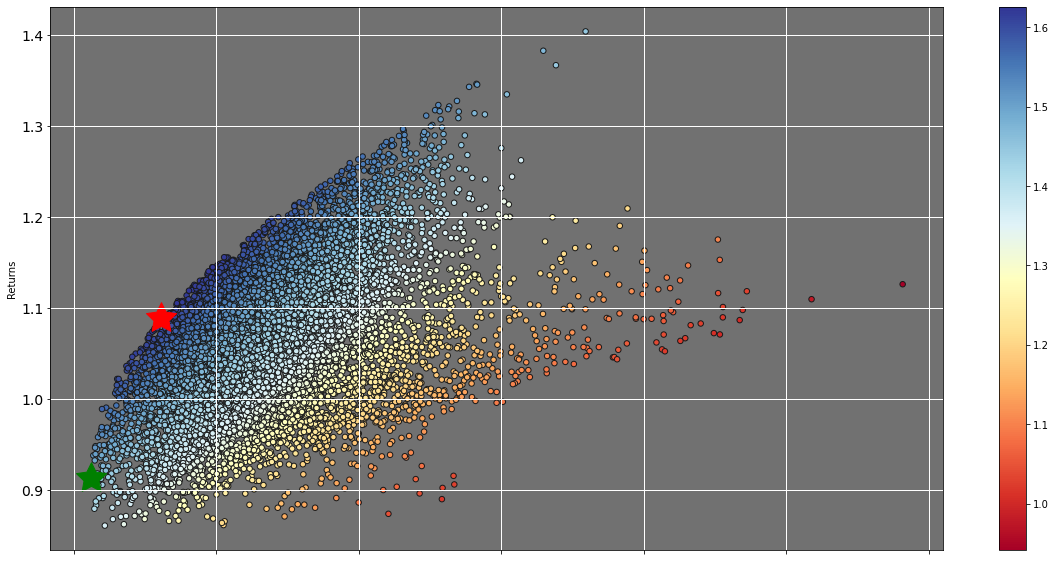

In [18]:
plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)
plt.show()